## Implementation and analysis of feature interference of the paper The Elephant in the Room

In [1]:
import sys
import os
import distutils.core
import torch
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

dist = distutils.core.run_setup("../detectron2/setup.py")
sys.path.insert(0, os.path.abspath('../detectron2'))

# import some common detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from pycocotools.coco import COCO
import glob
import copy
import pickle

In [2]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Thu_Jun_11_22:26:48_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.0, V11.0.194
Build cuda_11.0_bu.relgpu_drvr445TC445_37.28540450_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [3]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
# Load dataset
annotations_path = "../datasets/MSCOCO/annotations/instances_val2017.json"
database_path = "../datasets/MSCOCO/val2017/"
coco_annotation=COCO(annotations_path)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


In [5]:
print(coco_annotation.info())

description: COCO 2017 Dataset
url: http://cocodataset.org
version: 1.0
year: 2017
contributor: COCO Consortium
date_created: 2017/09/01
None


### Load an image with masks and change inside/outside of bounding boxes

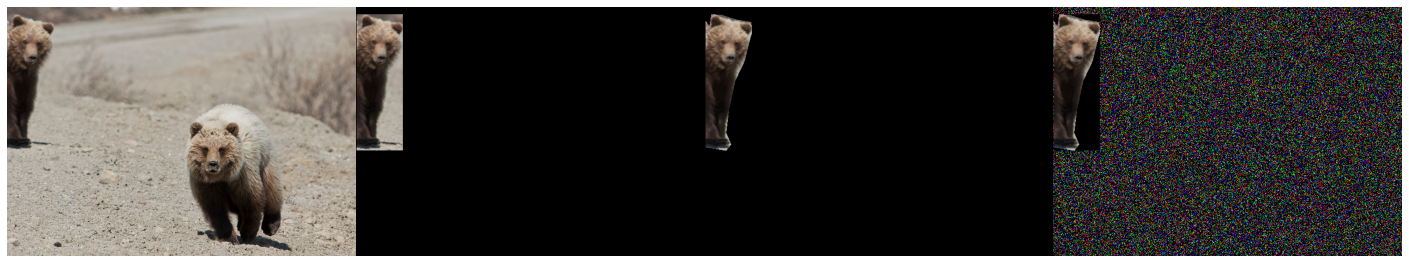

In [65]:
def load_image_with_masks(annotations, img_filename, database_path, instance=-1, outside_distribution='zeros', inside_distribution='original'):
    im = cv2.imread(database_path+img_filename)
    im_id = int(img_filename.split('.')[0])
    annotation_ids = annotations.getAnnIds(imgIds=im_id)
    
    num_annotations = len(annotation_ids)
    if instance == -1:
        annotation_id = annotation_ids[random.randint(0, len(annotation_ids)-1)]
    else:
        annotation_id = annotation_ids[instance]
    
    annotation_im  = annotations.loadAnns(annotation_id)[0]
    
    annotation_mask = annotations.annToMask(annotation_im)
    
    # Set everything outside bounding box to certain distribution
    if outside_distribution == 'zeros':
        im_feature_interference = np.zeros(im.shape, dtype=im.dtype)
    elif outside_distribution == 'noise':
        im_feature_interference = np.random.randn(*im.shape).astype(im.dtype)
    elif outside_distribution == 'original':
        im_feature_interference = copy.deepcopy(im)
        
    
    # Now change everything inside the bounding box and apply mask
    if inside_distribution == 'zeros':
        im_feature_interference[int(annotation_im['bbox'][1]):int(annotation_im['bbox'][1]+annotation_im['bbox'][3]),
                        int(annotation_im['bbox'][0]):int(annotation_im['bbox'][0]+annotation_im['bbox'][2])] = 0
    elif inside_distribution == 'original':
        im_feature_interference[int(annotation_im['bbox'][1]):int(annotation_im['bbox'][1]+annotation_im['bbox'][3]),
                        int(annotation_im['bbox'][0]):int(annotation_im['bbox'][0]+annotation_im['bbox'][2])] = im[int(annotation_im['bbox'][1]):int(annotation_im['bbox'][1]+annotation_im['bbox'][3]),
                        int(annotation_im['bbox'][0]):int(annotation_im['bbox'][0]+annotation_im['bbox'][2])]
    elif inside_distribution == 'noise':
        im_feature_interference[int(annotation_im['bbox'][1]):int(annotation_im['bbox'][1]+annotation_im['bbox'][3]),
                        int(annotation_im['bbox'][0]):int(annotation_im['bbox'][0]+annotation_im['bbox'][2])] = np.random.randn(*im.shape).astype(im.dtype)[int(annotation_im['bbox'][1]):int(annotation_im['bbox'][1]+annotation_im['bbox'][3]),
                        int(annotation_im['bbox'][0]):int(annotation_im['bbox'][0]+annotation_im['bbox'][2])]
    
    im_feature_interference[annotation_mask != 0] = im[annotation_mask != 0]
    
    return im, im_feature_interference, num_annotations

im_filename = random.choice(os.listdir(database_path))
im_filename = '000000020247.jpg'

im_orig, im_outside_zeros, _ = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'zeros', 'original')
_, im_all_zeros, _ = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'zeros', 'zeros')
_, im_outside_zeros_inside_noise, _ = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'noise', 'zeros')

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(25, 20)

ax[0].imshow(im_orig[:,:,::-1])
ax[0].axis('off')
ax[1].imshow(im_outside_zeros[:,:,::-1])
ax[1].axis('off')
ax[2].imshow(im_all_zeros[:,:,::-1])
ax[2].axis('off')
ax[3].imshow(im_outside_zeros_inside_noise[:,:,::-1])
ax[3].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Load model predictor and predict

In [7]:
cfg = get_cfg()
model = 'mask_rcnn'
if model == 'mask_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
elif model == 'fast_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE='cuda'
predictor = DefaultPredictor(cfg)

[03/27 02:41:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [8]:
def predict(predictor, img):
    outputs = predictor(img)
    output_predictions = outputs["instances"].pred_classes

    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    output_image= out.get_image()
    return output_image, output_predictions

We can use different objects to create the masks with outside and inside distribution

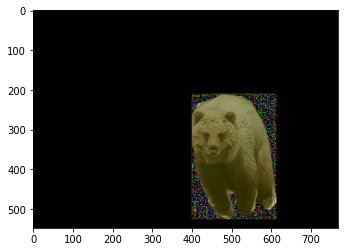

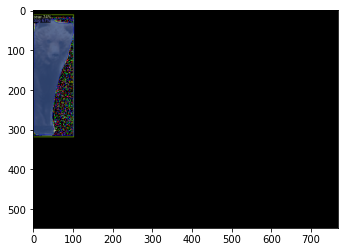

In [67]:
_, im_with_masks, num_annotations = load_image_with_masks(coco_annotation, im_filename, database_path, 0, 'zeros', 'noise')
im_predicted, predictions = predict(predictor, im_with_masks)
plt.imshow(im_predicted)
plt.show()

_, im_with_masks, num_annotations = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'zeros', 'noise')
im_predicted, predictions = predict(predictor, im_with_masks)
plt.imshow(im_predicted)
plt.show()

The Mask-RCNN classifier does not know whether a bear is a dog or a bear with certainty. We can notice that changing features inside the region-of-interest change the prediction, from not knowing whether is a dog or a bear, to just a bear. By contrast, when adding random noise to the outside of the bounding box and discarding all the pixels inside of it the only prediction is a dog.

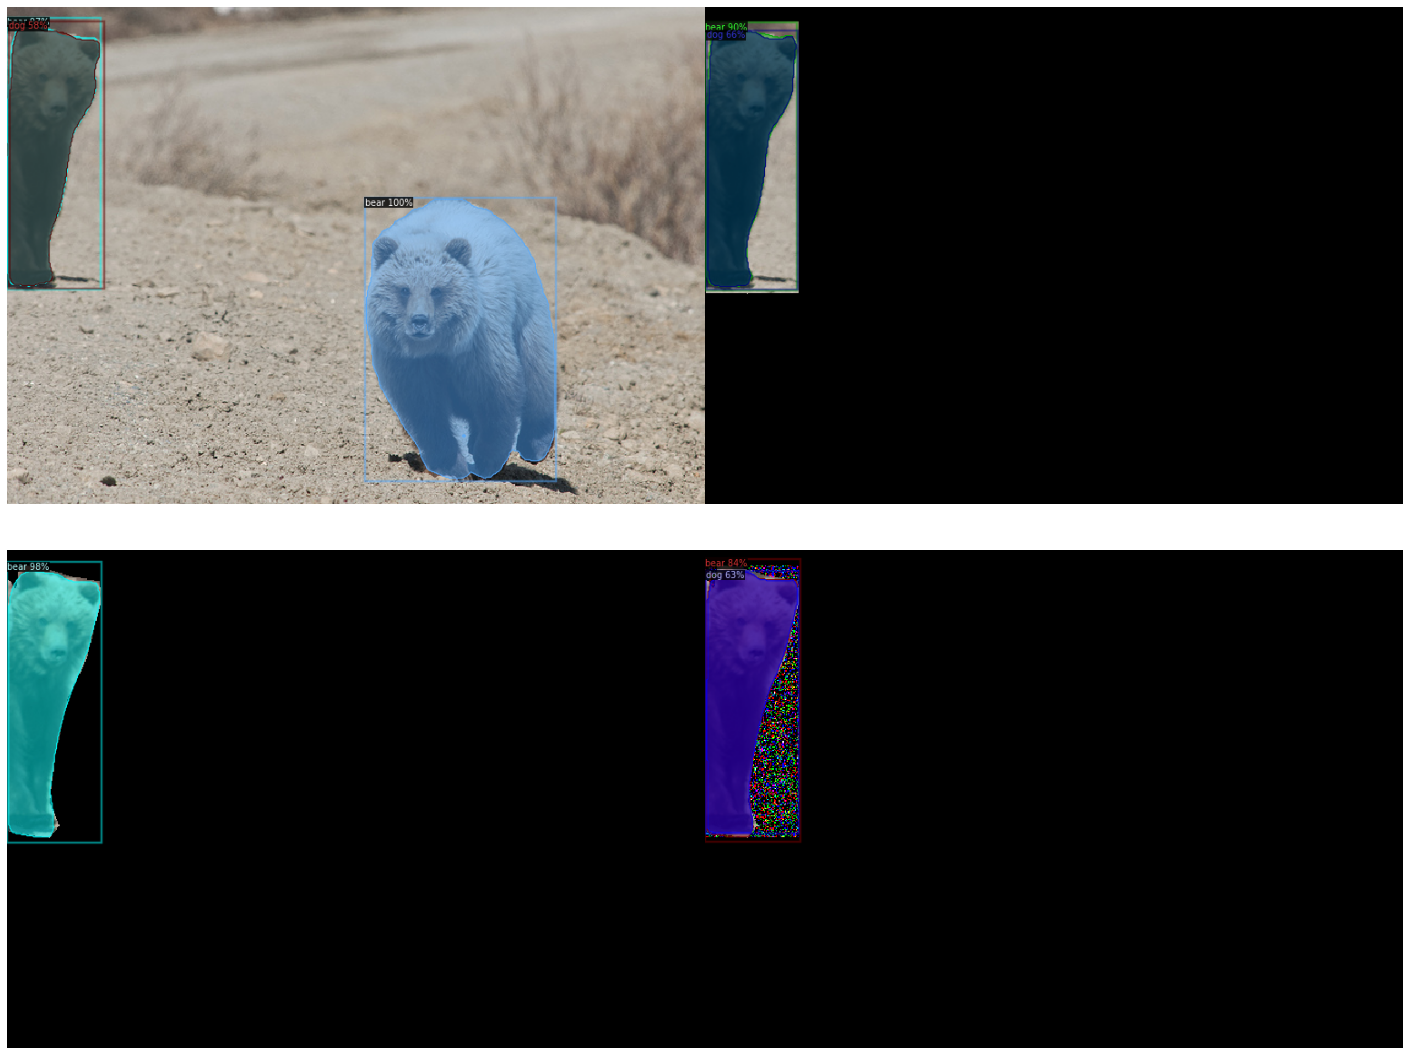

In [162]:
im_predicted_orig, predictions_orig = predict(predictor, im_orig)
im_predicted_outside_zeros, predictions_outside_zeros = predict(predictor, im_outside_zeros)
im_predicted_all_zeros, predictions_all_zeros = predict(predictor, im_all_zeros)
im_predicted_outside_zeros_inside_noise, predictions_outside_zeros_inside_noise = predict(predictor, im_outside_zeros_inside_noise)

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(25, 20)

ax[0,0].imshow(im_predicted_orig)
ax[0,0].axis('off')
ax[0,1].imshow(im_predicted_outside_zeros)
ax[0,1].axis('off')
ax[1,0].imshow(im_predicted_all_zeros)
ax[1,0].axis('off')
ax[1,1].imshow(im_predicted_outside_zeros_inside_noise)
ax[1,1].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Is the noise changing the prediction?

torch.Size([1])


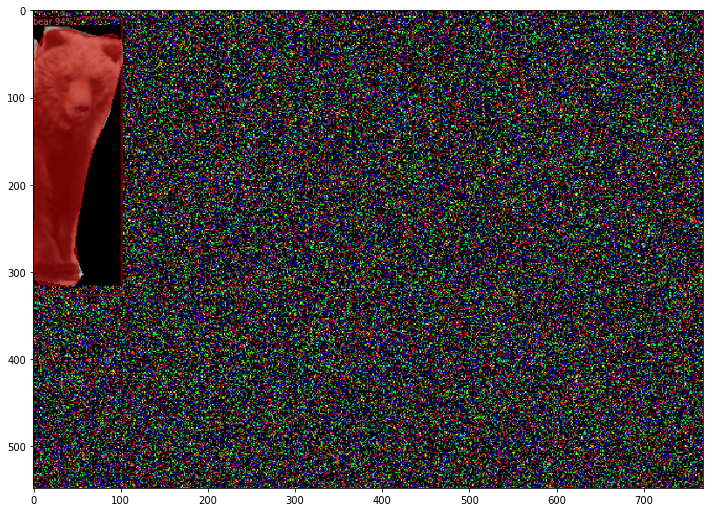

In [137]:
_, im_outside_zeros_inside_noise = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'noise', 'zeros')
im_predicted_outside_zeros_inside_noise, predictions_outside_zeros_inside_noise = predict(predictor, im_outside_zeros_inside_noise)
while len(predictions_outside_zeros_inside_noise.numpy()) != 1:
    _, im_outside_zeros_inside_noise = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'noise', 'zeros')
    im_predicted_outside_zeros_inside_noise, predictions_outside_zeros_inside_noise = predict(predictor, im_outside_zeros_inside_noise)
    
if len(predictions_outside_zeros_inside_noise.numpy()) != 2:
    print(predictions_outside_zeros_inside_noise.size())
    
    plt.figure(figsize=(12,12))
    plt.imshow(im_predicted_outside_zeros_inside_noise)

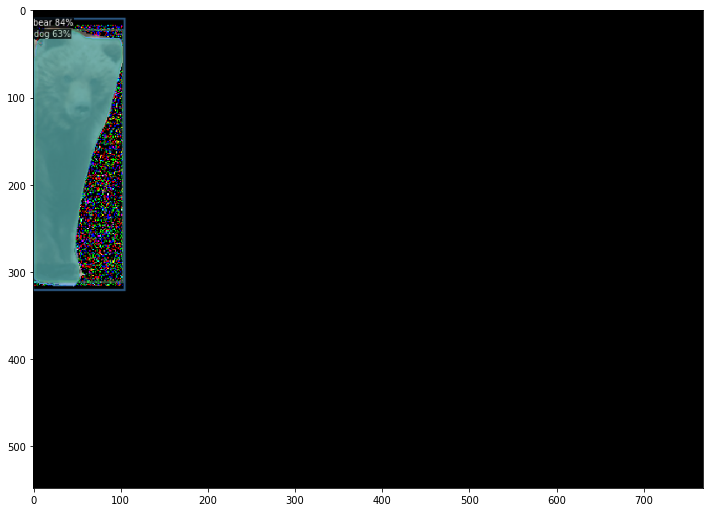

In [142]:
_, im_outside_zeros_inside_noise = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'zeros', 'noise')
im_predicted_outside_zeros_inside_noise, predictions_outside_zeros_inside_noise = predict(predictor, im_outside_zeros_inside_noise)
plt.figure(figsize=(12,12))
plt.imshow(im_predicted_outside_zeros_inside_noise)

### Lets analyse quantitatively

#### First we make predictions on the original images

In [17]:
prediction_originals = {}
filename = './outputs_task_d/all.pickle'

if os.path.isfile(filename):
    with open(filename, 'rb') as handle:
        prediction_originals = pickle.load(handle)
else:
    index = 0
    for im_filename in glob.glob(database_path+'/*'):
        im_filename = os.path.basename(im_filename)
        prediction_originals[im_filename] = []
        
        im_filename = os.path.basename(im_filename)
        im = cv2.imread(database_path+im_filename)
        im_predicted, predictions = predict(predictor, im)
        
        prediction_originals[im_filename].append(predictions.cpu().numpy().tolist())
            
        index += 1
        
    with open(filename, 'wb') as handle:
        pickle.dump(prediction_originals, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
print(len(prediction_originals.keys()))

5000


### Then we load the original images with predictions on different distributions

In [19]:
def load_prediction_results(outside_distribution, inside_distribution):
    index = 0

    prediction_results = {}

    for im_filename in glob.glob(database_path+'/*'):
        im_filename = os.path.basename(im_filename)
        prediction_results[im_filename] = []
        
        _, im_with_masks, num_annotations = load_image_with_masks(coco_annotation, im_filename, database_path, 0, outside_distribution, inside_distribution)
        im_predicted, predictions = predict(predictor, im_with_masks)
        prediction_results[im_filename].append(predictions.cpu().numpy().tolist())
        
        # Load left annotations too
        for i in range(1, num_annotations):
            _, im_with_masks, num_annotations = load_image_with_masks(coco_annotation, im_filename, database_path, i, outside_distribution, inside_distribution)
            im_predicted, predictions = predict(predictor, im_with_masks)
            prediction_results[im_filename].append(predictions.cpu().numpy().tolist())
            
        index += 1
        
    return prediction_results

In [20]:
prediction_results_dict = {}
distributions = ['zeros', 'noise', 'original']
for outside_distribution in distributions:
    for inside_distribution in distributions:            
        filename = './outputs_task_d/prediction_results_'+outside_distribution+'_'+inside_distribution+'.pickle'
        if os.path.isfile(filename):
            with open(filename, 'rb') as handle:
                prediction_results = pickle.load(handle)
        else:
            prediction_results = load_prediction_results(outside_distribution, inside_distribution)
            with open(filename, 'wb') as handle:
                pickle.dump(prediction_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
        prediction_results_dict[outside_distribution+'_'+inside_distribution] = prediction_results

In [63]:
def difference(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2]
    return lst3

difference_results_dict = {}
sum_differences = []
name_differences = []

for outside_distribution in distributions:
    for inside_distribution in distributions:
        difference_results_dict[outside_distribution+'_'+inside_distribution] = {}
        for key, value in prediction_results_dict[outside_distribution+'_'+inside_distribution].items():
            for elem in difference(np.concatenate(value), np.array(prediction_originals[key], dtype=np.float32).ravel()):
                if elem not in difference_results_dict[outside_distribution+'_'+inside_distribution]:
                    difference_results_dict[outside_distribution+'_'+inside_distribution][elem] = 1
                else:
                    difference_results_dict[outside_distribution+'_'+inside_distribution][elem] += 1
            
        sum_differences.append(sum(difference_results_dict[outside_distribution+'_'+inside_distribution].values()))
        name_differences.append(outside_distribution+'_'+inside_distribution)

raw_data = {'names': name_differences, 'differences': sum_differences}
del raw_data['names'][-1]
del raw_data['differences'][-1]

We can observe that having inside noise on the distribution modifies the results a lot with respect to not having it

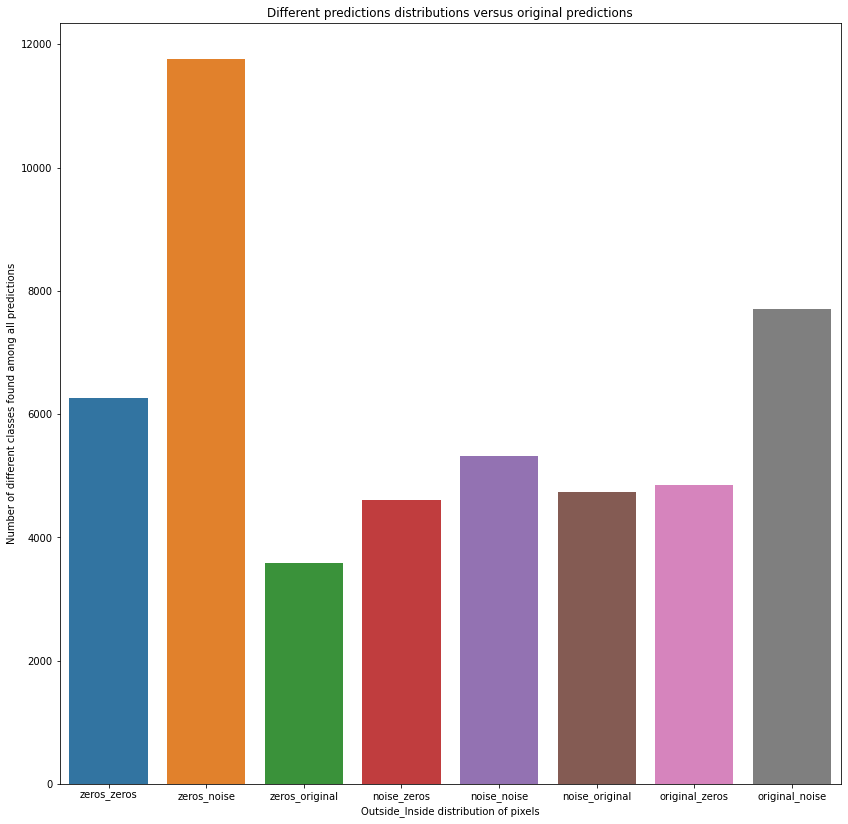

In [64]:
import seaborn as sns
plt.figure(figsize=(14,14))
plt.title('Different predictions distributions versus original predictions')
plt.xlabel('Outside_Inside distribution of pixels')
plt.ylabel('Number of different classes found among all predictions')
ax = sns.barplot(x='names', y='differences', data=raw_data)